In [1]:
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()


def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 15,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    task_loss = 0
    total_samples = 0
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = data
        total_samples += input_tensor.shape[0]
        for task_number in range(input_tensor.shape[0]):
            task_input = input_tensor[task_number]
            task_output = output_tensor[task_number]
            ex_input = example_input[task_number]
            ex_output = example_output[task_number]
            model.train()
            optimizer.zero_grad()
            prediction = model(task_input, ex_input, ex_output)
            prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
            task_output = task_output.squeeze(1)
            loss = criterion(prediction, task_output)
            #print(f'Task {task_number+1}/{kwargs["task_numbers"]}, Loss: {loss.item()}')
            loss.backward()
            optimizer.step()
            task_loss += loss.item()
            
    task_loss /= total_samples

    model.eval()
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data in tqdm(eval_loader, desc='Validation'):
            input_tensor, output_tensor, example_input, example_output = data
            total_samples += input_tensor.shape[0] * 900
            for task_number in range(input_tensor.shape[0]):
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                ex_input = example_input[task_number]
                ex_output = example_output[task_number]
                prediction = model(task_input, ex_input, ex_output)
                prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
                # total += example_output.size(0)
                correct += (prediction_class == task_output).sum().item()
        show_grid_side_by_side(task_input, task_output, prediction_class)        
                
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {task_loss}, Accuracy: {100 * correct / total_samples}%')

Epoch 1/15


Validation:  67%|██████▋   | 28/42 [01:08<00:28,  2.05s/it]

Epoch 1/15


Validation: 100%|██████████| 42/42 [00:08<00:00,  5.18it/s]


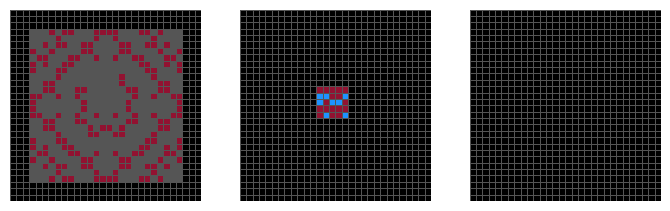

Epoch 1/15, Loss: 1.0226204704063444, Accuracy: 84.86324786324786%
Epoch 2/15


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.65it/s]


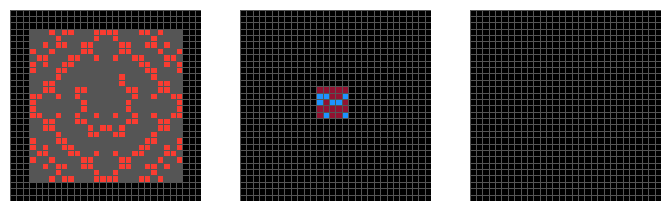

Epoch 2/15, Loss: 0.7063201857874026, Accuracy: 84.86324786324786%
Epoch 3/15


Validation: 100%|██████████| 42/42 [00:10<00:00,  4.02it/s]


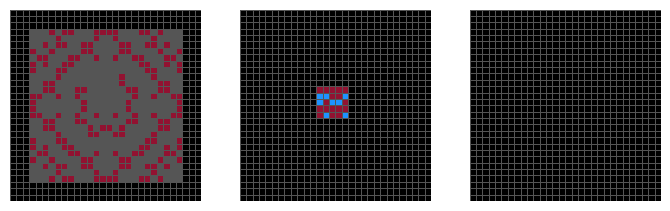

Epoch 3/15, Loss: 0.6324492644052953, Accuracy: 84.86324786324786%
Epoch 4/15


Validation:  79%|███████▊  | 33/42 [00:09<00:02,  3.80it/s]

In [1]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def criterion(y_pred, y):
    y = y.long()
    ce = F.cross_entropy(y_pred, y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 15,
    'task_numbers': 10,  # equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20,  # equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
}

# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

# 모델을 GPU로 이동
model = BWNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    task_loss = 0
    total_samples = 0
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]  # 데이터를 GPU로 이동
        total_samples += input_tensor.shape[0]
        for task_number in range(input_tensor.shape[0]):
            task_input = input_tensor[task_number]
            task_output = output_tensor[task_number]
            ex_input = example_input[task_number]
            ex_output = example_output[task_number]
            model.train()
            optimizer.zero_grad()
            prediction = model(task_input, ex_input, ex_output)
            prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
            task_output = task_output.squeeze(1)
            loss = criterion(prediction, task_output)
            loss.backward()
            optimizer.step()
            task_loss += loss.item()
            
    task_loss /= total_samples

    model.eval()
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data in tqdm(eval_loader, desc='Validation'):
            input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]  # 데이터를 GPU로 이동
            total_samples += input_tensor.shape[0] * 900
            for task_number in range(input_tensor.shape[0]):
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                ex_input = example_input[task_number]
                ex_output = example_output[task_number]
                prediction = model(task_input, ex_input, ex_output)
                prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
                correct += (prediction_class == task_output).sum().item()

        show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())  # CPU로 이동하여 시각화
                
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {task_loss}, Accuracy: {100 * correct / total_samples}%')


In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in train_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3

In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in eval_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3